![Two data scientists working on a dashboard.](hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that your dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

You've been hired by a major online data science training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

You've been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so you can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column                   | Description                                                                      |
|------------------------- |--------------------------------------------------------------------------------- |
| `student_id`             | A unique ID for each student.                                                    |
| `city`                   | A code for the city the student lives in.                                        |
| `city_development_index` | A scaled development index for the city.                                         |
| `gender`                 | The student's gender.                                                            |
| `relevant_experience`    | An indicator of the student's work relevant experience.                          |
| `enrolled_university`    | The type of university course enrolled in (if any).                              |
| `education_level`        | The student's education level.                                                   |
| `major_discipline`       | The educational discipline of the student.                                       |
| `experience`             | The student's total work experience (in years).                                  |
| `company_size`           | The number of employees at the student's current employer.                       |
| `company_type`           | The type of company employing the student.                                       |
| `last_new_job`           | The number of years between the student's current and previous jobs.             |
| `training_hours`         | The number of hours of training completed.                                       |
| `job_change`             | An indicator of whether the student is looking for a new job (`1`) or not (`0`). |

project link:  https://projects.datacamp.com/projects/1600

## Requirements

1) Columns containing categories with only two factors must be stored as Booleans (`bool`).
2) Columns containing integers only must be stored as 32-bit integers (`int32`).
3) Columns containing floats must be stored as 16-bit floats (`float16`).
4) Columns containing nominal categorical data must be stored as the `category` data type.
5) Columns containing ordinal categorical data must be stored as *ordered categories*, and not mapped to numerical values, with an order that reflects the natural order of the column.
6) The DataFrame should be filtered to only contain students with *10 or more years* of experience at companies with *at least 1000 employees*, as their recruiter base is suited to more experienced professionals at enterprise companies.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
ds_jobs = pd.read_csv("customer_train.csv")

# View the dataset
ds_jobs.head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.920,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevant experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevant experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevant experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevant experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [2]:
# Create a copy of ds_jobs for transforming
ds_jobs_transformed = ds_jobs.copy()

init_memory = ds_jobs_transformed.memory_usage(index=False, deep=True)
print(f"total original memory usage before tranformation: {init_memory.sum()} bytes \n")
print(ds_jobs_transformed.info())

total original memory usage before tranformation: 12391577 bytes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_id              19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevant_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  job_change              

In [3]:
# make a list of the columns that are categorical
string_cols = ["city", "gender", "relevant_experience", "enrolled_university", "education_level",
               "major_discipline", "experience", "company_size", "company_type", "last_new_job"]

for s_col in string_cols:
    print(ds_jobs_transformed[s_col].value_counts(), "\n")

city
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: count, Length: 123, dtype: int64 

gender
Male      13221
Female     1238
Other       191
Name: count, dtype: int64 

relevant_experience
Has relevant experience    13792
No relevant experience      5366
Name: count, dtype: int64 

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64 

education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64 

major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64 

experience
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7 

## 1. Columns containing categories with only two factors must be stored as Booleans (bool).

In [4]:
# which string columns are binary?
for s_col in string_cols:
    print(f"{s_col} has {len(ds_jobs_transformed[s_col].unique())} factors")

city has 123 factors
gender has 4 factors
relevant_experience has 2 factors
enrolled_university has 4 factors
education_level has 6 factors
major_discipline has 7 factors
experience has 23 factors
company_size has 9 factors
company_type has 7 factors
last_new_job has 7 factors


In [5]:
# before conversion
print(ds_jobs["relevant_experience"].value_counts(), "\n")

relevant_experience
Has relevant experience    13792
No relevant experience      5366
Name: count, dtype: int64 



In [6]:
# map 1 to having experience, 0 to not having experience
ds_jobs_transformed["relevant_experience"] = np.where(
    ds_jobs_transformed["relevant_experience"].str.contains("Has", regex=False), 1, 0).astype(bool)
ds_jobs_transformed["relevant_experience"].value_counts()

relevant_experience
True     13792
False     5366
Name: count, dtype: int64

In [13]:
# suspect that enrolled_university might be binary, so let's check
ds_jobs_transformed["enrolled_university"].value_counts()  # looks like this variable has 3 levels

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64

## 2. Columns containing integers only must be stored as 32-bit integers (int32).

There are only 2 integer columns: `student_id` and `training_hours`

In [7]:
ds_jobs_transformed['student_id'] = ds_jobs_transformed['student_id'].astype(np.int32)
ds_jobs_transformed['training_hours'] = ds_jobs_transformed['training_hours'].astype(np.int32)
ds_jobs_transformed.dtypes

student_id                  int32
city                       object
city_development_index    float64
gender                     object
relevant_experience          bool
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int32
job_change                float64
dtype: object

## 3. Columns containing floats must be stored as 16-bit floats (float16).

There are only 2 float columns: `city_development_index` and `job_change`.

Let's take a quick look at how these are distributed to see if they are really float values

<Axes: >

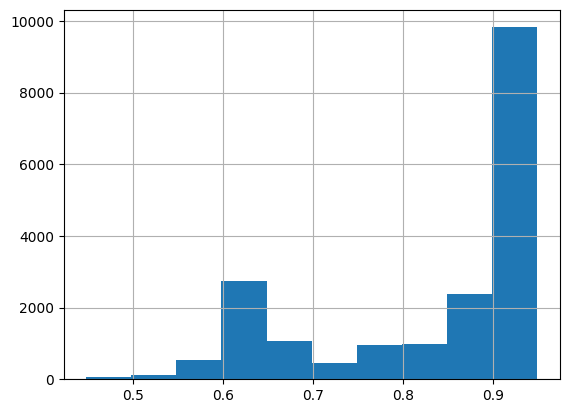

In [8]:
ds_jobs_transformed["city_development_index"].hist()  # these look like they really are floats, so convert to float16

In [9]:
ds_jobs_transformed["city_development_index"] = ds_jobs_transformed["city_development_index"].astype(np.float16)
ds_jobs_transformed.dtypes

student_id                  int32
city                       object
city_development_index    float16
gender                     object
relevant_experience          bool
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int32
job_change                float64
dtype: object

<Axes: >

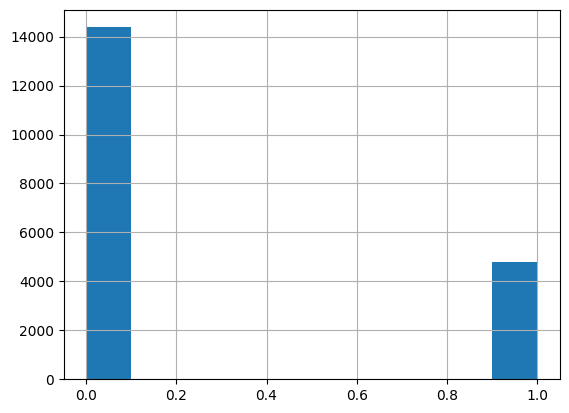

In [10]:
ds_jobs_transformed["job_change"].hist()  # this columns looks like it's actually binary 1 or 0

In [11]:
ds_jobs_transformed["job_change"].value_counts()  # sure enough, this column is indeed binary

job_change
0.0    14381
1.0     4777
Name: count, dtype: int64

In [12]:
# convert to bool as required
ds_jobs_transformed["job_change"] = ds_jobs_transformed["job_change"].astype(bool)
ds_jobs_transformed.dtypes

student_id                  int32
city                       object
city_development_index    float16
gender                     object
relevant_experience          bool
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int32
job_change                   bool
dtype: object